(exercise-solutions-geopandas1)=
# From "Vector layers (`geopandas`)"

In [57]:
!echo Last updated: `date +"%Y-%m-%d %H:%M:%S"`

Last updated: 2022-06-18 16:17:47


In [58]:
from myst_nb import glue

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 10
pd.options.display.max_columns = 10
pd.options.display.max_colwidth = 35
plt.rcParams["figure.figsize"] = (6, 6)

*****

## Exercise 08-a

In [60]:
import geopandas as gpd

In [61]:
# Read and subset
stat = gpd.read_file("data/statisticalareas_demography2019.gdb")
stat = stat[["YISHUV_STAT11", "SHEM_YISHUV", "SHEM_YISHUV_ENGLISH", "Pop_Total", "geometry"]]

In [62]:
# Examine CRS
stat.crs

<Projected CRS: EPSG:2039>
Name: Israel 1993 / Israeli TM Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Israel - onshore; Palestine Territory - onshore.
- bounds: (34.17, 29.45, 35.69, 33.28)
Coordinate Operation:
- name: Israeli TM
- method: Transverse Mercator
Datum: Israel 1993
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [63]:
# Feature count
stat.shape[0]

3195

In [64]:
# Are there any duplicates in the 'YISHUV_STAT11' column?
stat["YISHUV_STAT11"].duplicated().any()

False

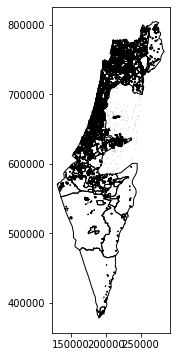

In [65]:
# Plot
stat.plot(edgecolor="black", color="none");

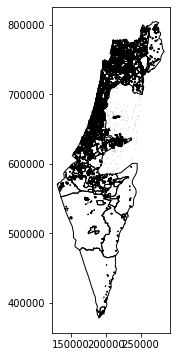

In [66]:
plot = stat.plot(edgecolor="black", color="none");
fig = plot.get_figure()
glue("exercise-08-a1", fig, display=False)

In [67]:
# Subset 'Beer-Sheva'
sel = stat["SHEM_YISHUV"] == "באר שבע"
stat1 = stat[sel]

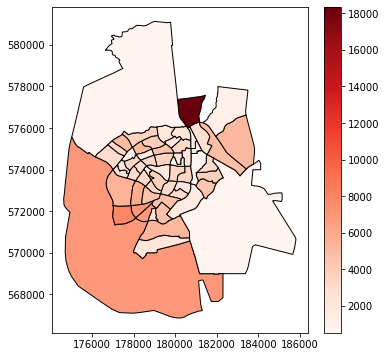

In [68]:
# Plot
stat1.plot(column="Pop_Total", edgecolor="black", cmap="Reds", legend=True);

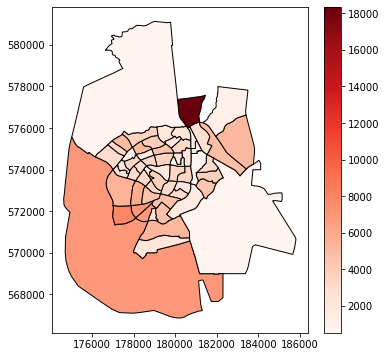

In [69]:
# Plot
plot = stat1.plot(column="Pop_Total", edgecolor="black", cmap="Reds", legend=True)
fig = plot.get_figure()
glue("exercise-08-a2", fig, display=False)

In [70]:
# Feature count
stat1.shape[0]

62

In [71]:
# Sum of population
stat1["Pop_Total"].sum()

209685.0

## Exercise 08-b

In [72]:
import pandas as pd
import geopandas as gpd
import shapely.geometry

In [73]:
# Read
agency = pd.read_csv("data/gtfs/agency.txt")
routes = pd.read_csv("data/gtfs/routes.txt")
trips = pd.read_csv("data/gtfs/trips.txt")
shapes = pd.read_csv("data/gtfs/shapes.txt")

In [74]:
# Subset
agency = agency[["agency_id", "agency_name"]]
routes = routes[["route_id", "agency_id", "route_short_name", "route_long_name"]]
trips = trips[["trip_id", "route_id", "shape_id"]]
shapes = shapes[["shape_id", "shape_pt_sequence", "shape_pt_lon", "shape_pt_lat"]]

In [75]:
# Subset agency
agency = agency[agency["agency_name"] == "דן באר שבע"]
routes = routes[routes["agency_id"] == agency["agency_id"].iloc[0]]
routes = routes.drop("agency_id", axis=1)

In [76]:
# Drop duplicate trips
trips = trips.drop_duplicates(subset="route_id")
trips = trips.drop("trip_id", axis=1)

In [77]:
# Join routes with shapes
routes = pd.merge(routes, trips, on="route_id", how="left")
routes = pd.merge(routes, shapes, on="shape_id", how="left")

In [78]:
# To points
geom = gpd.points_from_xy(routes["shape_pt_lon"], routes["shape_pt_lat"], crs=4326)
routes = gpd.GeoDataFrame(data=routes, geometry=geom)
routes = routes.drop(["shape_pt_lon", "shape_pt_lat"], axis=1)

In [79]:
# To lines
routes = routes.groupby("route_id").agg({
    "route_short_name": "first",
    "route_long_name": "first",
    "geometry": lambda x: shapely.geometry.LineString(x.to_list()),
}).reset_index()
routes = gpd.GeoDataFrame(routes, crs=4326)
routes

route_id route_short_name                     route_long_name  \
0        142               2א  שד. הצנחנים / צבי בן יעקב-באר ש...   
1        143               2א  מסוף רמות-באר שבע<->שד. הצנחנים...   
2        178              14א  ת. רכבת ב''ש צפון-באר שבע<->שד....   
3        180              14א  שד. הצנחנים / צבי בן יעקב-באר ש...   
4        185              16א  כפר האירוסים/דרך אילן רמון-באר ...   
..       ...              ...                                 ...   
66     27981               27  ת.מרכזית/עירוניים לדרום-באר שבע...   
67     27982              27א  הברזל/החורש-באר שבע<->מכללה טכנ...   
68     27983               27  מכללה טכנולוגית חיל האוויר/דרך ...   
69     27984              27א  מכללה טכנולוגית חיל האוויר/דרך ...   
70     28740              18א  ת.מרכזית/עירוניים לדרום-באר שבע...   

                              geometry  
0   LINESTRING (34.77787 31.22497, ...  
1   LINESTRING (34.82207 31.28003, ...  
2   LINESTRING (34.80885 31.26133, ...  
3   LINESTRING (34.77787 31.22497, ...  
4   LINESTRING (34.75704 31.25477, ...  
..                                 ...  
66  LINESTRING (34.79791 31.24329, ...  
67  LINESTRING (34.80872 31.21809, ...  
68  LINESTRING (34.75665 31.25459, ...  
69  LINESTRING (34.75665 31.25459, ...  
70  LINESTRING (34.79791 31.24329, ...  

[71 rows x 4 columns]

In [80]:
# Calculate start points
pnt = [shapely.geometry.Point(line.coords[0]) for line in routes["geometry"].to_list()]
pnt = gpd.GeoSeries(pnt, crs=4326)
pnt

0     POINT (34.77787 31.22497)
1     POINT (34.82207 31.28003)
2     POINT (34.80885 31.26133)
3     POINT (34.77787 31.22497)
4     POINT (34.75704 31.25477)
                ...            
66    POINT (34.79791 31.24329)
67    POINT (34.80872 31.21809)
68    POINT (34.75665 31.25459)
69    POINT (34.75665 31.25459)
70    POINT (34.79791 31.24329)
Length: 71, dtype: geometry

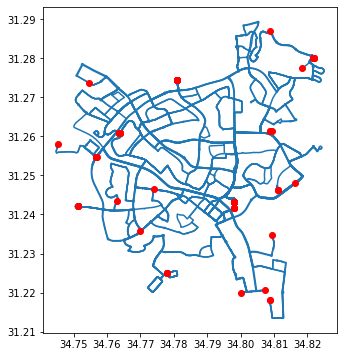

In [81]:
# Plot
base = routes.plot(zorder=1)
pnt.plot(ax=base, color="red", zorder=2);

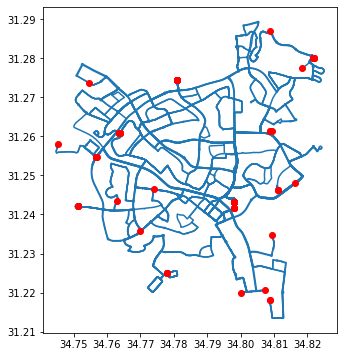

In [82]:
# Plot
base = routes.plot(zorder=1)
pnt.plot(ax=base, color="red", zorder=2)
fig = base.get_figure()
glue("exercise-08-b", fig, display=False)

## Exercise 08-c

In [83]:
import geopandas as gpd

# Read
stat = gpd.read_file("data/statisticalareas_demography2019.gdb")

# Subset columns
sel = ["SHEM_YISHUV", "age_0_4", "age_5_9", "age_10_14", "age_15_19", "Pop_Total"]
stat = stat[sel]
stat

SHEM_YISHUV  age_0_4  age_5_9  age_10_14  age_15_19  Pop_Total
0           המעפיל     72.0     89.0      109.0       73.0      869.0
1          משגב עם     34.0     15.0       19.0       26.0      339.0
2           גאולים     77.0     86.0       92.0       69.0      968.0
3       להבות הבשן     56.0     78.0       99.0       87.0      915.0
4           מכמורת    116.0    130.0      121.0       79.0     1403.0
...            ...      ...      ...        ...        ...        ...
3190   קריית נטפים    165.0    165.0      151.0       67.0      958.0
3191          דולב    215.0    190.0      174.0      143.0     1448.0
3192        עתניאל    115.0    108.0      118.0      158.0     1044.0
3193          יצהר    412.0    357.0      240.0       81.0     1726.0
3194  מבואות יריחו      NaN      NaN        NaN        NaN        NaN

[3195 rows x 6 columns]

In [84]:
# Replace "No Data" with zero
sel = ["age_0_4", "age_5_9", "age_10_14", "age_15_19", "Pop_Total"]
stat[sel] = stat[sel].fillna(0)
stat

SHEM_YISHUV  age_0_4  age_5_9  age_10_14  age_15_19  Pop_Total
0           המעפיל     72.0     89.0      109.0       73.0      869.0
1          משגב עם     34.0     15.0       19.0       26.0      339.0
2           גאולים     77.0     86.0       92.0       69.0      968.0
3       להבות הבשן     56.0     78.0       99.0       87.0      915.0
4           מכמורת    116.0    130.0      121.0       79.0     1403.0
...            ...      ...      ...        ...        ...        ...
3190   קריית נטפים    165.0    165.0      151.0       67.0      958.0
3191          דולב    215.0    190.0      174.0      143.0     1448.0
3192        עתניאל    115.0    108.0      118.0      158.0     1044.0
3193          יצהר    412.0    357.0      240.0       81.0     1726.0
3194  מבואות יריחו      0.0      0.0        0.0        0.0        0.0

[3195 rows x 6 columns]

In [85]:
# Subset towns with total population >5000
sel = stat["Pop_Total"] > 5000
stat = stat[sel].copy()
stat

SHEM_YISHUV  age_0_4  age_5_9  age_10_14  age_15_19  Pop_Total
28       ירושלים   2579.0   2594.0     2431.0     2411.0    23581.0
29       ירושלים   3161.0   2997.0     2815.0     2786.0    22258.0
30       ירושלים   1714.0   1585.0     1373.0     1364.0    11336.0
31       ירושלים   2469.0   2436.0     2369.0     2378.0    19591.0
32       ירושלים   3393.0   3293.0     3172.0     3267.0    29503.0
...          ...      ...      ...        ...        ...        ...
3133       רעננה    797.0    668.0      527.0      411.0     6978.0
3136       רעננה    471.0    561.0      619.0      489.0     6680.0
3142       שפרעם   3506.0   3431.0     3637.0     4298.0    42137.0
3152        טמרה   3155.0   3206.0     3451.0     3700.0    34392.0
3172     באר שבע    437.0    400.0      384.0      393.0     5205.0

[471 rows x 6 columns]

In [86]:
# Calculate total population in ages 0-19
stat["Pop_Total_0_19"] = stat["age_0_4"] + stat["age_5_9"] + stat["age_10_14"] + stat["age_15_19"]
stat

SHEM_YISHUV  age_0_4  age_5_9  age_10_14  age_15_19  Pop_Total  \
28       ירושלים   2579.0   2594.0     2431.0     2411.0    23581.0   
29       ירושלים   3161.0   2997.0     2815.0     2786.0    22258.0   
30       ירושלים   1714.0   1585.0     1373.0     1364.0    11336.0   
31       ירושלים   2469.0   2436.0     2369.0     2378.0    19591.0   
32       ירושלים   3393.0   3293.0     3172.0     3267.0    29503.0   
...          ...      ...      ...        ...        ...        ...   
3133       רעננה    797.0    668.0      527.0      411.0     6978.0   
3136       רעננה    471.0    561.0      619.0      489.0     6680.0   
3142       שפרעם   3506.0   3431.0     3637.0     4298.0    42137.0   
3152        טמרה   3155.0   3206.0     3451.0     3700.0    34392.0   
3172     באר שבע    437.0    400.0      384.0      393.0     5205.0   

      Pop_Total_0_19  
28           10015.0  
29           11759.0  
30            6036.0  
31            9652.0  
32           13125.0  
...              ...  
3133          2403.0  
3136          2140.0  
3142         14872.0  
3152         13512.0  
3172          1614.0  

[471 rows x 7 columns]

In [87]:
# Aggregate
stat = stat.groupby("SHEM_YISHUV").sum().reset_index()
stat

SHEM_YISHUV  age_0_4  age_5_9  age_10_14  age_15_19  Pop_Total  \
0         אבו גוש    784.0    720.0      740.0      717.0     7698.0   
1        אבו סנאן   1281.0   1148.0     1229.0     1428.0    14099.0   
2       אבן יהודה    926.0   1335.0     1482.0     1158.0    13826.0   
3      אום אל-פחם   5639.0   5587.0     5955.0     6367.0    56109.0   
4          אופקים   3112.0   2519.0     1901.0     1489.0    21793.0   
..            ...      ...      ...        ...        ...        ...   
174    שערי תקווה    564.0    645.0      638.0      481.0     6039.0   
175         שפרעם   3506.0   3431.0     3637.0     4298.0    42137.0   
176  תל אביב -יפו   7217.0   6461.0     5473.0     4941.0    89404.0   
177       תל מונד    881.0   1202.0     1371.0     1346.0    13144.0   
178        תל שבע   3536.0   3083.0     2780.0     2770.0    20808.0   

     Pop_Total_0_19  
0            2961.0  
1            5086.0  
2            4901.0  
3           23548.0  
4            9021.0  
..              ...  
174          2328.0  
175         14872.0  
176         24092.0  
177          4800.0  
178         12169.0  

[179 rows x 7 columns]

In [88]:
# Calculate ratio
stat["ratio"] = stat["Pop_Total_0_19"] / stat["Pop_Total"]
stat

SHEM_YISHUV  age_0_4  age_5_9  age_10_14  age_15_19  Pop_Total  \
0         אבו גוש    784.0    720.0      740.0      717.0     7698.0   
1        אבו סנאן   1281.0   1148.0     1229.0     1428.0    14099.0   
2       אבן יהודה    926.0   1335.0     1482.0     1158.0    13826.0   
3      אום אל-פחם   5639.0   5587.0     5955.0     6367.0    56109.0   
4          אופקים   3112.0   2519.0     1901.0     1489.0    21793.0   
..            ...      ...      ...        ...        ...        ...   
174    שערי תקווה    564.0    645.0      638.0      481.0     6039.0   
175         שפרעם   3506.0   3431.0     3637.0     4298.0    42137.0   
176  תל אביב -יפו   7217.0   6461.0     5473.0     4941.0    89404.0   
177       תל מונד    881.0   1202.0     1371.0     1346.0    13144.0   
178        תל שבע   3536.0   3083.0     2780.0     2770.0    20808.0   

     Pop_Total_0_19     ratio  
0            2961.0  0.384645  
1            5086.0  0.360735  
2            4901.0  0.354477  
3           23548.0  0.419683  
4            9021.0  0.413940  
..              ...       ...  
174          2328.0  0.385494  
175         14872.0  0.352944  
176         24092.0  0.269473  
177          4800.0  0.365186  
178         12169.0  0.584823  

[179 rows x 8 columns]

In [89]:
# Classify and sort
stat["type"] = "old"
sel = stat["ratio"] >= stat["ratio"].mean()
stat.loc[sel, "type"] = "young"
stat.sort_values(by="ratio")

SHEM_YISHUV  age_0_4  age_5_9  age_10_14  age_15_19  Pop_Total  \
149   קריית ביאליק    696.0    646.0      634.0      635.0    10980.0   
118            נשר    459.0    491.0      446.0      403.0     7123.0   
32        בני עי"ש    518.0    460.0      389.0      424.0     6978.0   
164         רמת גן   4106.0   3764.0     3511.0     3077.0    53747.0   
176   תל אביב -יפו   7217.0   6461.0     5473.0     4941.0    89404.0   
..             ...      ...      ...        ...        ...        ...   
63            חורה   4087.0   3553.0     3001.0     2799.0    22337.0   
29         בית שמש  18999.0  17515.0    14383.0     9976.0   100881.0   
10            אלעד   7271.0   8064.0     8142.0     6457.0    48764.0   
30      ביתר עילית   9963.0   8915.0     7437.0     4291.0    46889.0   
105  מודיעין עילית  14246.0  13303.0     9782.0     5517.0    62919.0   

     Pop_Total_0_19     ratio   type  
149          2611.0  0.237796    old  
118          1799.0  0.252562    old  
32           1791.0  0.256664    old  
164         14458.0  0.269001    old  
176         24092.0  0.269473    old  
..              ...       ...    ...  
63          13440.0  0.601692  young  
29          60873.0  0.603414  young  
10          29934.0  0.613854  young  
30          30606.0  0.652733  young  
105         42848.0  0.681003  young  

[179 rows x 9 columns]

In [90]:
glue("exercise-08-c", stat.sort_values(by="ratio"))

SHEM_YISHUV  age_0_4  age_5_9  age_10_14  age_15_19  Pop_Total  \
149   קריית ביאליק    696.0    646.0      634.0      635.0    10980.0   
118            נשר    459.0    491.0      446.0      403.0     7123.0   
32        בני עי"ש    518.0    460.0      389.0      424.0     6978.0   
164         רמת גן   4106.0   3764.0     3511.0     3077.0    53747.0   
176   תל אביב -יפו   7217.0   6461.0     5473.0     4941.0    89404.0   
..             ...      ...      ...        ...        ...        ...   
63            חורה   4087.0   3553.0     3001.0     2799.0    22337.0   
29         בית שמש  18999.0  17515.0    14383.0     9976.0   100881.0   
10            אלעד   7271.0   8064.0     8142.0     6457.0    48764.0   
30      ביתר עילית   9963.0   8915.0     7437.0     4291.0    46889.0   
105  מודיעין עילית  14246.0  13303.0     9782.0     5517.0    62919.0   

     Pop_Total_0_19     ratio   type  
149          2611.0  0.237796    old  
118          1799.0  0.252562    old  
32           1791.0  0.256664    old  
164         14458.0  0.269001    old  
176         24092.0  0.269473    old  
..              ...       ...    ...  
63          13440.0  0.601692  young  
29          60873.0  0.603414  young  
10          29934.0  0.613854  young  
30          30606.0  0.652733  young  
105         42848.0  0.681003  young  

[179 rows x 9 columns]

## Exercise 08-d

In [98]:
import pandas as pd
import geopandas as gpd
import shapely.geometry

In [99]:
# Read
agency = pd.read_csv("data/gtfs/agency.txt")
routes = pd.read_csv("data/gtfs/routes.txt")
trips = pd.read_csv("data/gtfs/trips.txt")
shapes = pd.read_csv("data/gtfs/shapes.txt")

In [100]:
# Subset
agency = agency[["agency_id", "agency_name"]]
routes = routes[["route_id", "agency_id", "route_short_name", "route_long_name"]]
trips = trips[["trip_id", "route_id", "shape_id"]]
shapes = shapes[["shape_id", "shape_pt_sequence", "shape_pt_lon", "shape_pt_lat"]]

In [101]:
# Subset agency
agency = agency[agency["agency_name"] == "מטרופולין"]
routes = routes[routes["agency_id"] == agency["agency_id"].iloc[0]]
routes = routes.drop("agency_id", axis=1)

In [102]:
# Drop duplicate trips
trips = trips.drop_duplicates(subset="route_id")
trips = trips.drop("trip_id", axis=1)

In [103]:
# Join routes with shapes
routes = pd.merge(routes, trips, on="route_id", how="left")
routes = pd.merge(routes, shapes, on="shape_id", how="left")

In [104]:
# To points
geom = gpd.points_from_xy(routes["shape_pt_lon"], routes["shape_pt_lat"], crs=4326)
routes = gpd.GeoDataFrame(data=routes, geometry=geom)
routes = routes.drop(["shape_pt_lon", "shape_pt_lat"], axis=1)

In [105]:
# To lines
routes = routes.groupby("route_id").agg({
    "route_short_name": "first",
    "route_long_name": "first",
    "geometry": lambda x: shapely.geometry.LineString(x.to_list()),
}).reset_index()
routes = gpd.GeoDataFrame(routes, crs=4326)

In [92]:
# Calculate 'delta_lon' and 'delta_lat'
b = routes.bounds
delta_lon = b["maxx"] - b["minx"]
delta_lat = b["maxy"] - b["miny"]

In [93]:
# Subset maximum 'delta_lon' and 'delta_lat'
routes1 = routes.iloc[[delta_lon.idxmax(), delta_lat.idxmax()], :]
routes1

route_id route_short_name                     route_long_name  \
560     26209              400  מלון הוד-תמר<->ת. רכבת להבים רה...   
310     11718              660  מרכז תפוח-מצפה רמון<->ת. מרכזית...   

                               geometry  
560  LINESTRING (35.36330 31.20181, ...  
310  LINESTRING (34.80221 30.61085, ...

In [94]:
# Print
glue("exercise-08-d1", routes1)

route_id route_short_name                     route_long_name  \
560     26209              400  מלון הוד-תמר<->ת. רכבת להבים רה...   
310     11718              660  מרכז תפוח-מצפה רמון<->ת. מרכזית...   

                               geometry  
560  LINESTRING (35.36330 31.20181, ...  
310  LINESTRING (34.80221 30.61085, ...

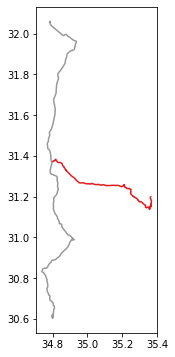

In [97]:
# Plot
routes1.plot(column="route_short_name", cmap="Set1");

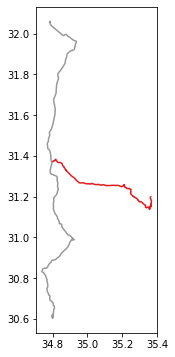

In [95]:
plot = routes1.plot(column="route_short_name", cmap="Set1")
fig = plot.get_figure()
glue("exercise-08-d2", fig, display=False)